Following https://medium.com/technovators/machine-learning-based-multi-label-text-classification-9a0e17f88bb4

In [1]:
import sys
sys.path.append('/usr/local/lib/python3.9/site-packages')

In [2]:
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn import metrics

import pandas as pd
import numpy as np
import pickle
import json

import matplotlib.pyplot as plt
import umap
from mlxtend.plotting import plot_decision_regions

import scipy


In [3]:
train_dict = pickle.load(open('data/train.pkl', 'rb'))
valid_dict = pickle.load(open('data/valid.pkl', 'rb'))
test_dict = pickle.load(open('data/test.pkl', 'rb'))

In [4]:
# combine valid and test - approx 80/20 split
test_dict = {**valid_dict, **test_dict}

In [24]:
len(train_dict)

52416

In [25]:
len(test_dict)

4538

In [5]:
# Save certain keys only

def load_dict(d:dict):
    
    d_new = {i:{'input': d[i]['input'],
                 'label': d[i]['label'].split(';'),
                 'label_vec': d[i]['label_vec'], 
                 'lemmas': d[i]['lemmas']}
              for i in d
              if len(d[i]['lemmas']) != 0}
    
    return d_new


train_dict = load_dict(train_dict)
# valid_dict = load_dict(valid_dict)
test_dict = load_dict(test_dict)

In [6]:
train_data = pd.DataFrame.from_dict(train_dict, orient='index')
# valid_data = pd.DataFrame.from_dict(valid_dict, orient='index')
test_data = pd.DataFrame.from_dict(test_dict, orient='index')

In [7]:
vectorizer = TfidfVectorizer()
vectorised_train_documents = vectorizer.fit_transform(train_data["input"])
vectorised_test_documents = vectorizer.transform(test_data["input"])

In [8]:
mlb = MultiLabelBinarizer()
train_labels = mlb.fit_transform(train_data['label'])
test_labels = mlb.transform(test_data['label'])


In [9]:
svmClassifier = OneVsRestClassifier(LinearSVC(), n_jobs=-1)
# svmClassifier = CalibratedClassifierCV(svmClassifier)
svmClassifier.fit(vectorised_train_documents, train_labels)

svmPreds = svmClassifier.predict(vectorised_test_documents)
# svmProba = svmClassifier._predict_proba_lr(vectorised_test_documents)

svmDF = svmClassifier.decision_function(vectorised_test_documents)

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, hamming_loss

In [11]:
accuracy_score(test_labels, svmPreds)

0.881225209343323

In [12]:
f1_score(test_labels, svmPreds, average='micro')

0.9423452492145707

In [13]:
precision_score(test_labels, svmPreds, average='micro')

0.9532726335681154

In [14]:
recall_score(test_labels, svmPreds, average='micro')

0.9316655473472129

In [15]:
with open('map_labels.json', 'r') as f:
    map_labels = json.load(f)

# map_labels
# map_labels_rev = {map_labels[i]:i for i in map_labels}

In [16]:
print(metrics.classification_report(test_labels, svmPreds, target_names=map_labels.keys()))


                      precision    recall  f1-score   support

         Case Report       0.95      0.89      0.92       773
           Diagnosis       0.97      0.94      0.95       297
Epidemic Forecasting       0.95      0.93      0.94       954
        General Info       0.99      0.99      0.99       104
           Mechanism       1.00      0.67      0.80        18
          Prevention       0.97      0.96      0.97       685
        Transmission       0.94      0.94      0.94      1625
           Treatment       0.98      0.90      0.94       153
                           0.95      0.94      0.95      1347

           micro avg       0.95      0.93      0.94      5956
           macro avg       0.97      0.90      0.93      5956
        weighted avg       0.95      0.93      0.94      5956
         samples avg       0.94      0.94      0.93      5956



/Users/yohyoh.wang/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
# Which categories did the model perform best and worst on? 
confusion_matrix = metrics.multilabel_confusion_matrix(test_labels, svmPreds)

Text(0.5, 1.0, 'General Info')

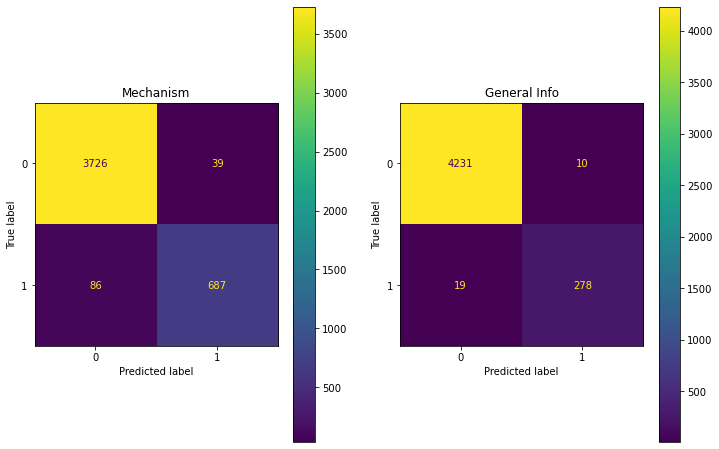

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

disp1 = metrics.ConfusionMatrixDisplay(confusion_matrix[0]).plot(ax=ax1)
disp1.ax_.set_title('Mechanism')

disp2 = metrics.ConfusionMatrixDisplay(confusion_matrix[1]).plot(ax=ax2)
disp2.ax_.set_title('General Info')

In [19]:
metrics.roc_auc_score(test_labels, svmDF, average=None)

array([0.99266307, 0.9989433 , 0.99584573, 0.99998699, 0.99985251,
       0.99871027, 0.9914237 , 0.99969444, 0.99510548])

In [20]:
# The coverage_error function computes the average number of labels that have to be included in the final prediction such that all true labels are predicted. This is useful if you want to know how many top-scored-labels you have to predict in average without missing any true one. 
# The best value of this metrics is thus the average number of true labels.

metrics.coverage_error(test_labels, svmPreds)

1.9587924195680917

In [21]:
map_labels

{'Case Report': 0,
 'Diagnosis': 1,
 'Epidemic Forecasting': 2,
 'General Info': 3,
 'Mechanism': 4,
 'Prevention': 5,
 'Transmission': 6,
 'Treatment': 7,
 '': 8}